# PK/PD AL Model Calibration

## Calibrating PK/PD Model to output AL Efficacy = 0.965 or 96.5% for weight = 54 Kg

<br>

In [659]:
import subprocess
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys
import time
import datetime 
from math import *

<br>

# Getting the ec50_lum for efficacies for 4 genetic loci from analysis on 06/05

## pfcrt K76: 92.5%
## pfcrt 76T: 91.9%
## pfmdr1 N86: 87.5%
## pfmdr1 86Y: 100%

<br>

In [2]:
n_patients = 10000
experiment = "04"
file_suffix = f"calibration_ec50_lum_adjusted_{experiment}"
folder = f"AL_calibration_pmax_lum_vs_efficacy_results_{experiment}"

# Load the data

data_ec50_lum = pd.read_csv(f"/home/venitha_b/Projects/2019-test-ppq-pk/model_calibration_AL/pfcrt76/062025/06052025/AL_calibration_base/{folder}/pkpd_AL_{file_suffix}.csv")

data_ec50_lum.head()

,ec50_lum,efficacy
0,1.00,100.00
1,5.99,100.00
2,10.98,99.98
3,15.97,99.84
4,20.96,99.78


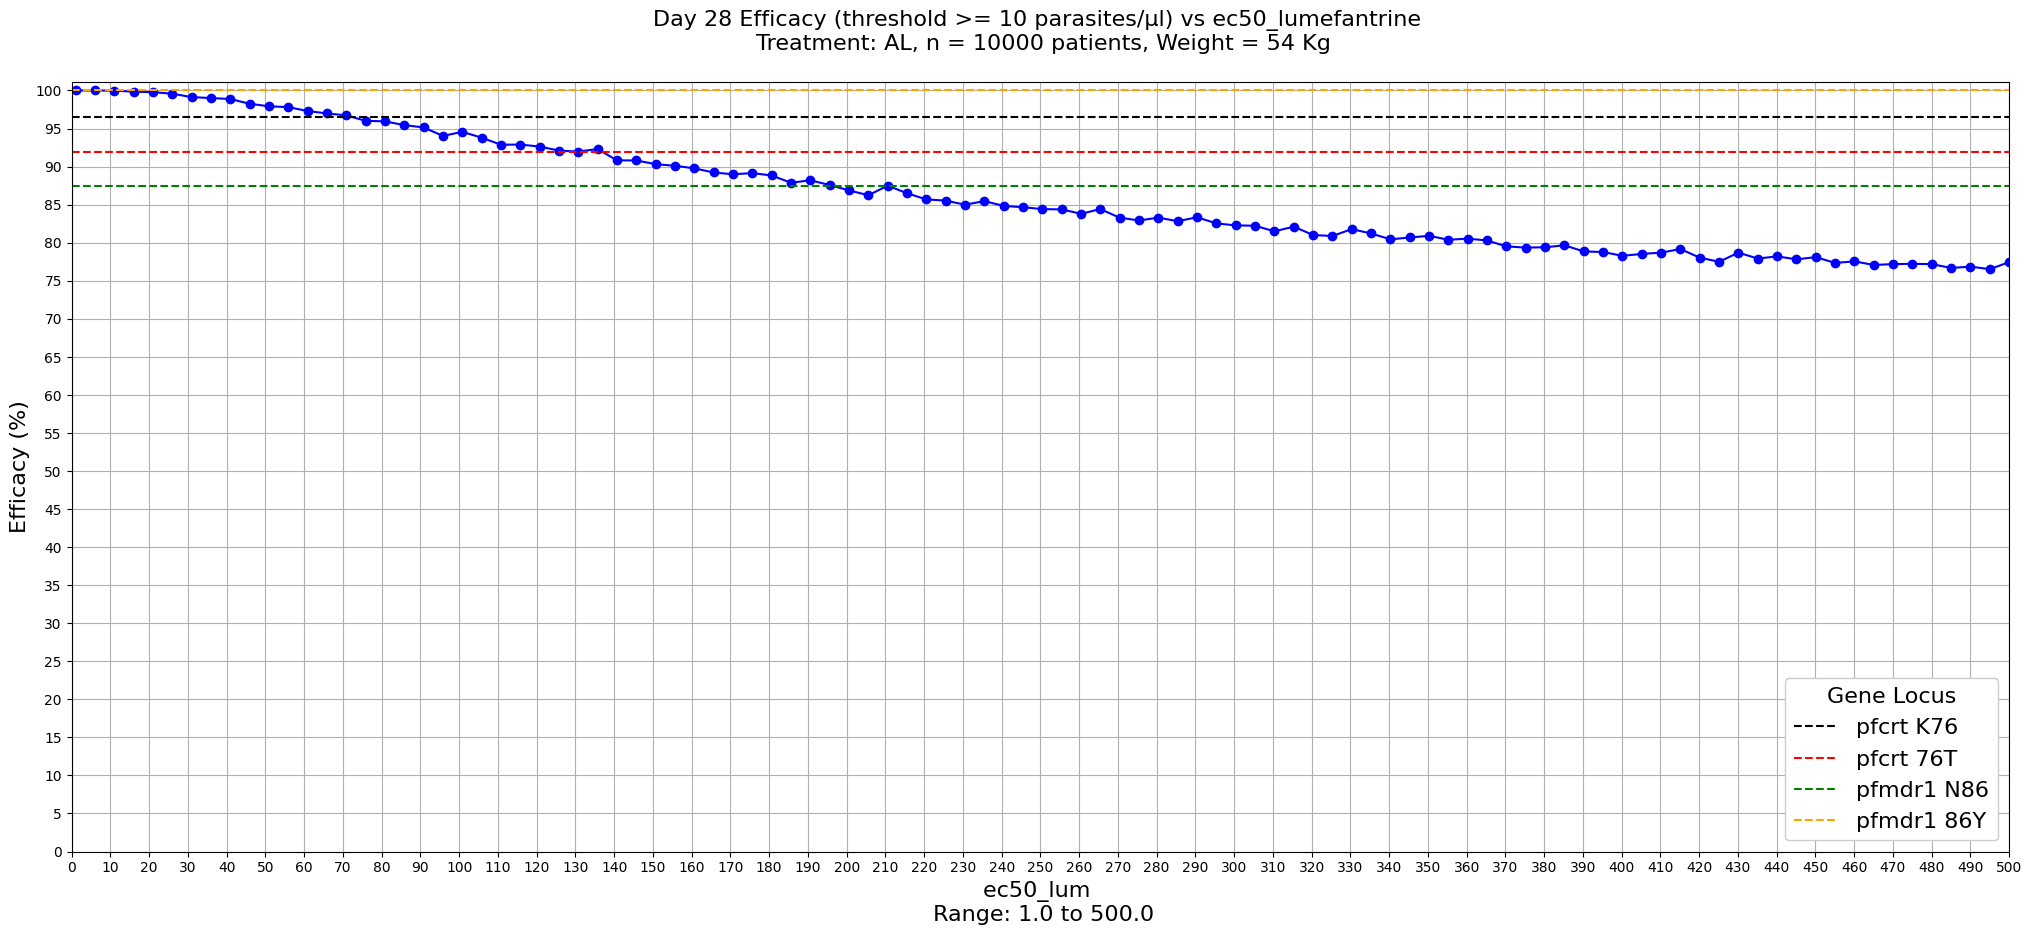

In [3]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(data_ec50_lum['ec50_lum'], data_ec50_lum['efficacy'], marker='o', linestyle='-', color='b')
plt.xlabel(f'ec50_lum \n Range: {min(data_ec50_lum['ec50_lum'])} to {max(data_ec50_lum['ec50_lum'])}',fontsize="16")
plt.ylabel('Efficacy (%)',fontsize="16")
plt.title(f"Day 28 Efficacy (threshold >= 10 parasites/μl) vs ec50_lumefantrine \n Treatment: AL, n = {n_patients} patients, Weight = 54 Kg\n", fontsize="16")
plt.grid(True)
plt.xlim(min(data_ec50_lum['ec50_lum']), max(data_ec50_lum['ec50_lum']))  # Set x-axis limits
plt.xticks(np.arange(0, max(data_ec50_lum['ec50_lum'])+10,10))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=96.5, color='k', linestyle='--', label="pfcrt K76")  # Optional: horizontal line at y=96.5%
plt.axhline(y=91.9, color='r', linestyle='--', label="pfcrt 76T")  # Optional: horizontal line at y=91.9%
plt.axhline(y=87.5, color='g', linestyle='--', label="pfmdr1 N86")  # Optional: horizontal line at y=87.5%
plt.axhline(y=100, color='orange', linestyle='--', label="pfmdr1 86Y")  # Optional: horizontal line at y=100%

plt.legend(framealpha=1, loc="lower right", title="Gene Locus", fontsize="16", title_fontsize="16")  # Show legend
#plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.savefig(f"pkpd_AL_{file_suffix}.png")  # Save the plot as a PNG file
plt.show()

In [655]:
# Sigmoid function
def sigmoid(x, L, x0, k, b):
    exp_term = np.exp(-np.clip(k * (x - x0), -700, 700))
    y = b + (L - b) / (1 + exp_term)
    return y

# Data
xdata = np.array(data_ec50_lum['ec50_lum'])
ydata = np.array(data_ec50_lum['efficacy'])
x_min, x_max = np.min(xdata), np.max(xdata)

# Normalize the original xdata for fitting
#xdata_norm = (xdata - x_min) / (x_max - x_min)

# --- 2. Fit the Curve using Original Data ---
# Initial guess
L = 100
x0 = np.median(xdata)  # Using median of xdata for initial x0
k = -0.005 # Steepness (can be tuned)
b = 1

# Define bounds for the parameters [L, x0, k, b]
# Lower bounds: L, x0, k, b
lower_bounds = [0, 0, -np.inf, 0]  
# Upper bounds: L, x0, k, b 
upper_bounds = [100, np.inf, 0, 100]

bounds = (lower_bounds, upper_bounds)

p0 = [L, x0, k, b]


# Note: xdata and ydata have the same length
#popt, pcov = curve_fit(sigmoid, xdata_norm, ydata, p0, bounds=bounds,maxfev=10000)
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, bounds=bounds,maxfev=10000)

print("L:", popt[0], "x0:", popt[1], "k:", popt[2], "b:", popt[3])


L: 99.99999999999999 x0: 186.60067718024067 k: -0.01339970714345046 b: 77.52559274002132


In [656]:
x_smooth = np.linspace(x_min, x_max, 10000)
#x_smooth_norm = (x_smooth - x_min) / (x_max - x_min)
#fitted_values = sigmoid(x_smooth_norm, *popt)
fitted_values = sigmoid(x_smooth, *popt)

# Function to extrapolate x given y
def extrapolate_x(y, L, x0, k, b):
    # Solve for x
    x = x0 - (1 / k) * np.log(((L-b) / (y - b)) - 1)
    #x = x0 - (1 / k) * np.log((L / y) - 1) # Without b 
    return x

# Example: Extrapolate x for a given y
y_target = 92.5 # Example efficacy value
#x_target_norm = extrapolate_x(y_target, *popt)
x_target = extrapolate_x(y_target, *popt)

# Rescale to original x range
#x_target = x_target_norm * (x_max - x_min) + x_min
print(f"The ec50 value x for the efficacy y = {y_target} is approximately {x_target:.10f}")

The ec50 value x for the efficacy y = 92.5 is approximately 134.9995837159


In [657]:
# Repeat for other efficacy values

y_targets = [87.5, 91.9, 92.5, 96.5, 99.999] # Example efficacy value
x_targets = []

for efficacy in y_targets:
    #x_target_norm = extrapolate_x(efficacy, *popt)
    x_target = extrapolate_x(efficacy, *popt)
    # Rescale to original x range
    #x_target = x_target_norm * (x_max - x_min) + x_min
    x_target = max(1, x_target) 
    x_targets.append(round(x_target,1))
    print(f"The ec50 value x for the efficacy y = {efficacy} is approximately {x_target:.10f}")

The ec50 value x for the efficacy y = 87.5 is approximately 203.4447845507
The ec50 value x for the efficacy y = 91.9 is approximately 143.7948692677
The ec50 value x for the efficacy y = 92.5 is approximately 134.9995837159
The ec50 value x for the efficacy y = 96.5 is approximately 60.4540309695
The ec50 value x for the efficacy y = 99.999 is approximately 1.0000000000


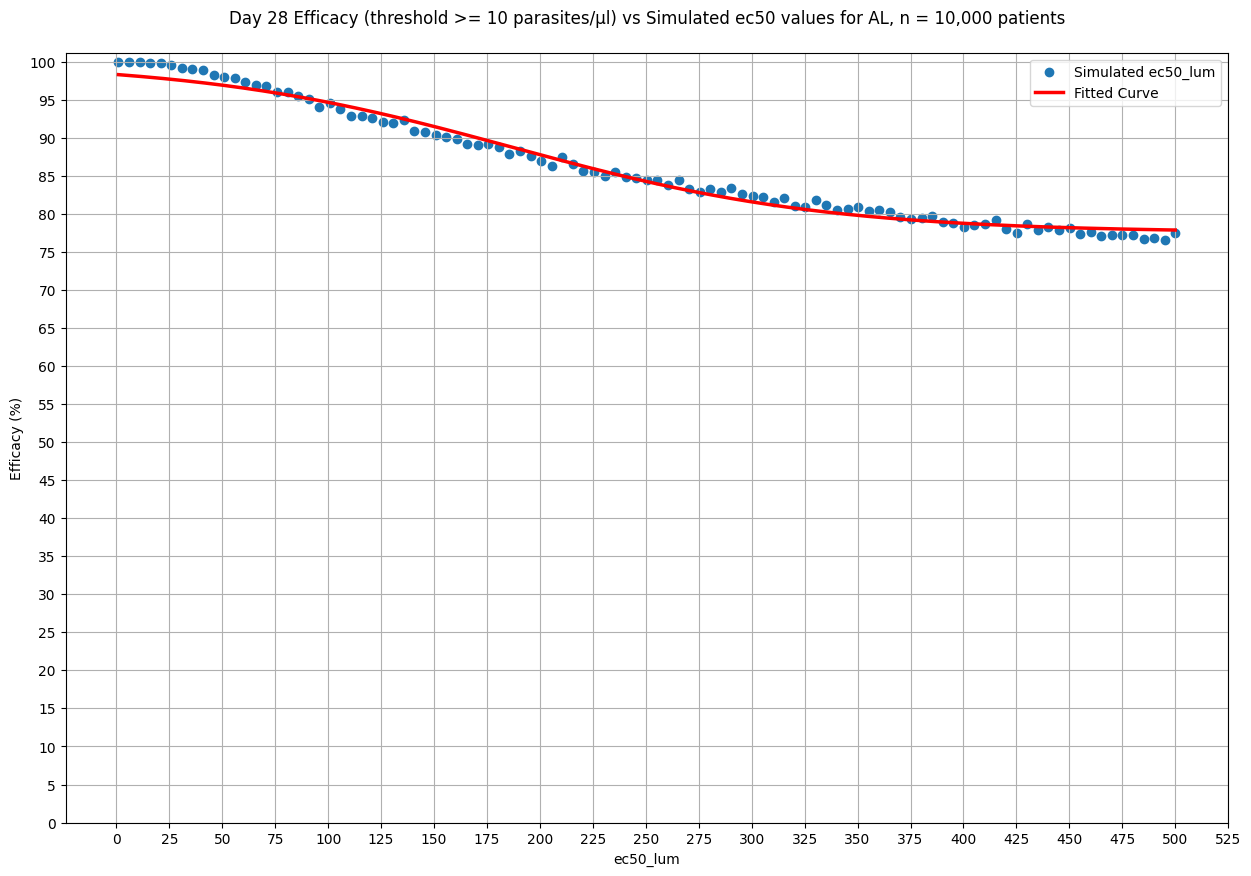

In [658]:
# Plot results
plt.figure(figsize=(15, 10))
plt.scatter(xdata, ydata, label='Simulated ec50_lum')
#plt.plot(xdata, fitted_values, label='Fitted Curve', color='red')
plt.plot(x_smooth, fitted_values, label='Fitted Curve', color='red', linewidth=2.5)

# for efficacy in y_targets:
#     plt.axhline(y=efficacy,linestyle='--', label=f'Target efficacy = {y_target}')
# for ec50 in x_targets:
#     plt.axvline(x=ec50, linestyle='--', label=f'Extrapolated ec50 = {ec50:.1f}')

plt.xticks(np.arange(0, max(data_ec50_lum['ec50_lum'])+26,25))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 102, 5))  # Y-axis ticks from min(ydata) to 100%
plt.xlabel("ec50_lum")
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated ec50 values for AL, n = 10,000 patients\n")
plt.legend()
plt.grid(True)
plt.savefig(f"pkpd_AL_{file_suffix}_sigmoid_01.png")
plt.show()

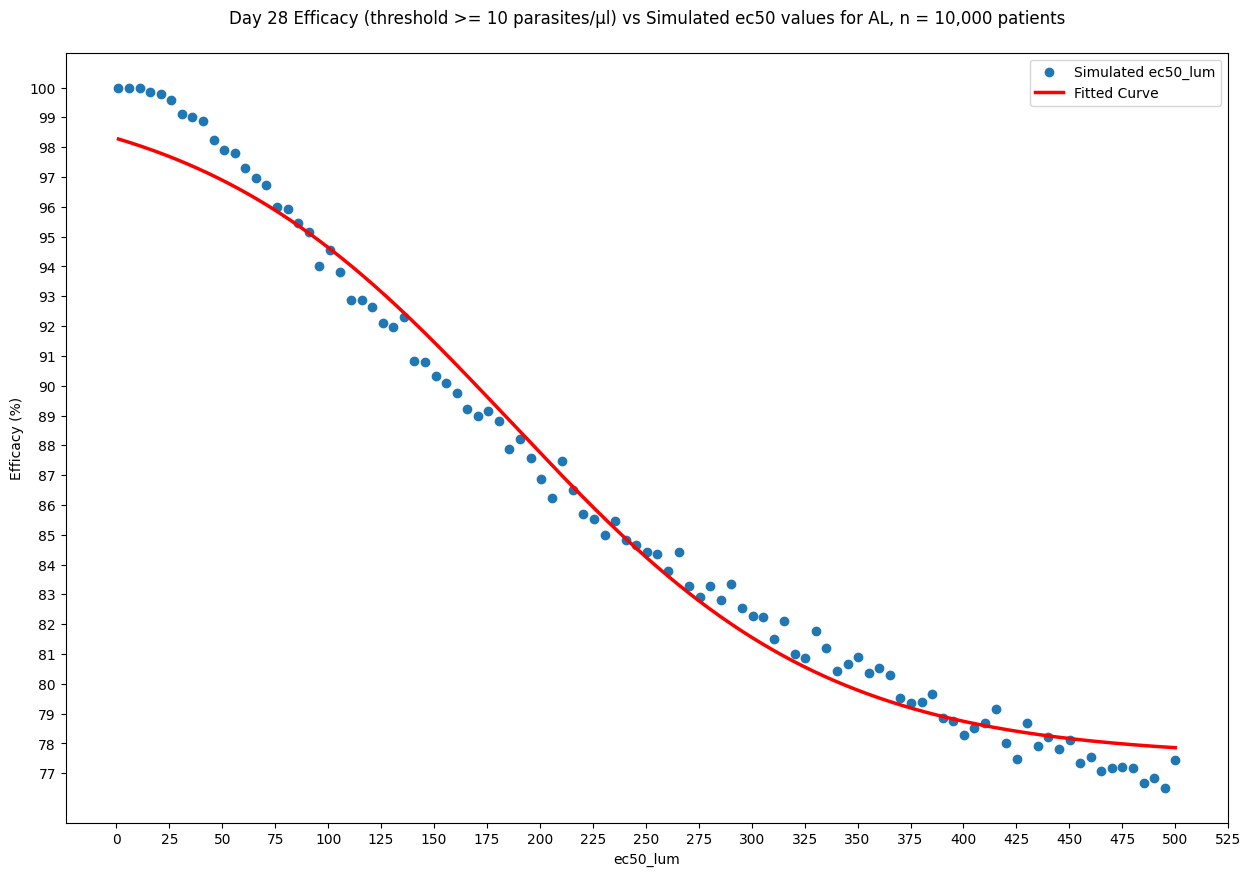

In [654]:
# Plot results
plt.figure(figsize=(15, 10))
plt.scatter(xdata, ydata, label='Simulated ec50_lum')
#plt.plot(xdata, fitted_values, label='Fitted Curve', color='red')
plt.plot(x_smooth, fitted_values, label='Fitted Curve', color='red', linewidth=2.5)

# for efficacy in y_targets:
#     plt.axhline(y=efficacy,linestyle='--', label=f'Target efficacy = {y_target}')
# for ec50 in x_targets:
#     plt.axvline(x=ec50, linestyle='--', label=f'Extrapolated ec50 = {ec50:.1f}')

plt.xticks(np.arange(0, max(data_ec50_lum['ec50_lum'])+26,25))  # Adjust tick marks if necessary
plt.yticks(np.arange(round(min(ydata), 0), 101, 1))  # Y-axis ticks from min(ydata) to 100%
plt.xlabel("ec50_lum")
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated ec50 values for AL, n = 10,000 patients\n")
plt.legend()
plt.savefig(f"pkpd_AL_{file_suffix}_sigmoid_02.png")
plt.show()

In [661]:
n_patients = 10000
experiment = "04"
file_suffix = f"calibration_ec50_lum_adjusted_{experiment}"
folder = f"AL_calibration_pmax_lum_vs_efficacy_results_{experiment}"

# Load the data

data_ec50_lum = pd.read_csv(f"/home/venitha_b/Projects/2019-test-ppq-pk/model_calibration_AL/pfcrt76/062025/06052025/AL_calibration_base/{folder}/pkpd_AL_{file_suffix}.csv")

data_ec50_lum.head()

,ec50_lum,efficacy
0,1.00,100.00
1,5.99,100.00
2,10.98,99.98
3,15.97,99.84
4,20.96,99.78


In [767]:
# Sigmoid function
def sigmoid_richards(x, L, x0, k, b, Q, v):
#def sigmoid_richards(x, L, x0, k, b, v):
    exp_term = np.exp(-np.clip(-k * (x - x0), -700, 700))
    y = b + (L-b)/((1 + (Q * exp_term))**(v))
    #y = b + (L-b)/((1 + (1 * exp_term))**(1/v))
    return y

# Data
xdata = np.array(data_ec50_lum['ec50_lum'])
ydata = np.array(data_ec50_lum['efficacy'])
x_min, x_max = np.min(xdata), np.max(xdata)

# Normalize the original xdata for fitting
#xdata_norm = (xdata - x_min) / (x_max - x_min)

# --- 2. Fit the Curve using Original Data ---
# Initial guess
L = 0
x0 = np.median(xdata)  # Using median of xdata for initial x0
k = -0 # Steepness (can be tuned)
b = 100
Q = 1
v = 1

# Define bounds for the parameters [L, x0, k, b, Q, v]
# Lower bounds: L, x0, k, b, Q, v
#lower_bounds = [0, 0, -np.inf, 0, -np.inf, 0]  
lower_bounds = [0, 0, -np.inf, 0, 0, -np.inf]  
# Upper bounds: L, x0, k, b 
upper_bounds = [100, np.inf, 0, 100, np.inf, np.inf]

bounds = (lower_bounds, upper_bounds)

p0 = [L, x0, k, b, Q, v]


# Note: xdata and ydata have the same length
#popt, pcov = curve_fit(sigmoid, xdata_norm, ydata, p0, bounds=bounds,maxfev=10000)
popt, pcov = curve_fit(sigmoid_richards, xdata, ydata, p0, bounds=bounds,maxfev=10000)

print("L:", popt[0], "x0:", popt[1], "k:", popt[2], "b:", popt[3], "Q:", popt[4], "v:", popt[5])


L: 76.19432019471596 x0: 1143.3769838777146 k: -0.00849550155552738 b: 99.99999999999999 Q: 1.4144432188069863e-06 v: 149.26074215589165


In [768]:
x_smooth = np.linspace(x_min, x_max, 10000)
#x_smooth_norm = (x_smooth - x_min) / (x_max - x_min)
#fitted_values = sigmoid(x_smooth_norm, *popt)
fitted_values_richards = sigmoid_richards(x_smooth, *popt)

# Function to extrapolate x given y
def extrapolate_x_richards(y, L, x0, k, b, Q, v):
    # Solve for x
    x = x0 - (1 / k) * np.log((((L-b) / (y - b))**v - 1)/Q)
    #x = x0 - (1 / k) * np.log((L / y) - 1) # Without b 
    return x

# Example: Extrapolate x for a given y
y_target = 92.5 # Example efficacy value
#x_target_norm = extrapolate_x(y_target, *popt)
x_target = extrapolate_x_richards(y_target, *popt)

# Rescale to original x range
#x_target = x_target_norm * (x_max - x_min) + x_min
print(f"The ec50 value x for the efficacy y = {y_target} is approximately {x_target:.10f}")

The ec50 value x for the efficacy y = 92.5 is approximately 23021.7901357548


In [766]:
# Repeat for other efficacy values

y_targets = [87.5, 91.9, 92.5, 96.5, 99.999] # Example efficacy value
x_targets = []

for efficacy in y_targets:
    #x_target_norm = extrapolate_x(efficacy, *popt)
    x_target = extrapolate_x_richards(efficacy, *popt)
    # Rescale to original x range
    #x_target = x_target_norm * (x_max - x_min) + x_min
    x_target = max(1, x_target) 
    x_targets.append(round(x_target,1))
    print(f"The ec50 value x for the efficacy y = {efficacy} is approximately {x_target:.10f}")

The ec50 value x for the efficacy y = 87.5 is approximately 51842.4208259326
The ec50 value x for the efficacy y = 91.9 is approximately inf
The ec50 value x for the efficacy y = 92.5 is approximately inf
The ec50 value x for the efficacy y = 96.5 is approximately inf
The ec50 value x for the efficacy y = 99.999 is approximately inf


/tmp/ipykernel_29150/3844077574.py:9: RuntimeWarning: overflow encountered in scalar divide
  x = x0 - (1 / k) * np.log((((L-b) / (y - b))**v - 1)/Q)
/tmp/ipykernel_29150/3844077574.py:9: RuntimeWarning: overflow encountered in scalar power
  x = x0 - (1 / k) * np.log((((L-b) / (y - b))**v - 1)/Q)


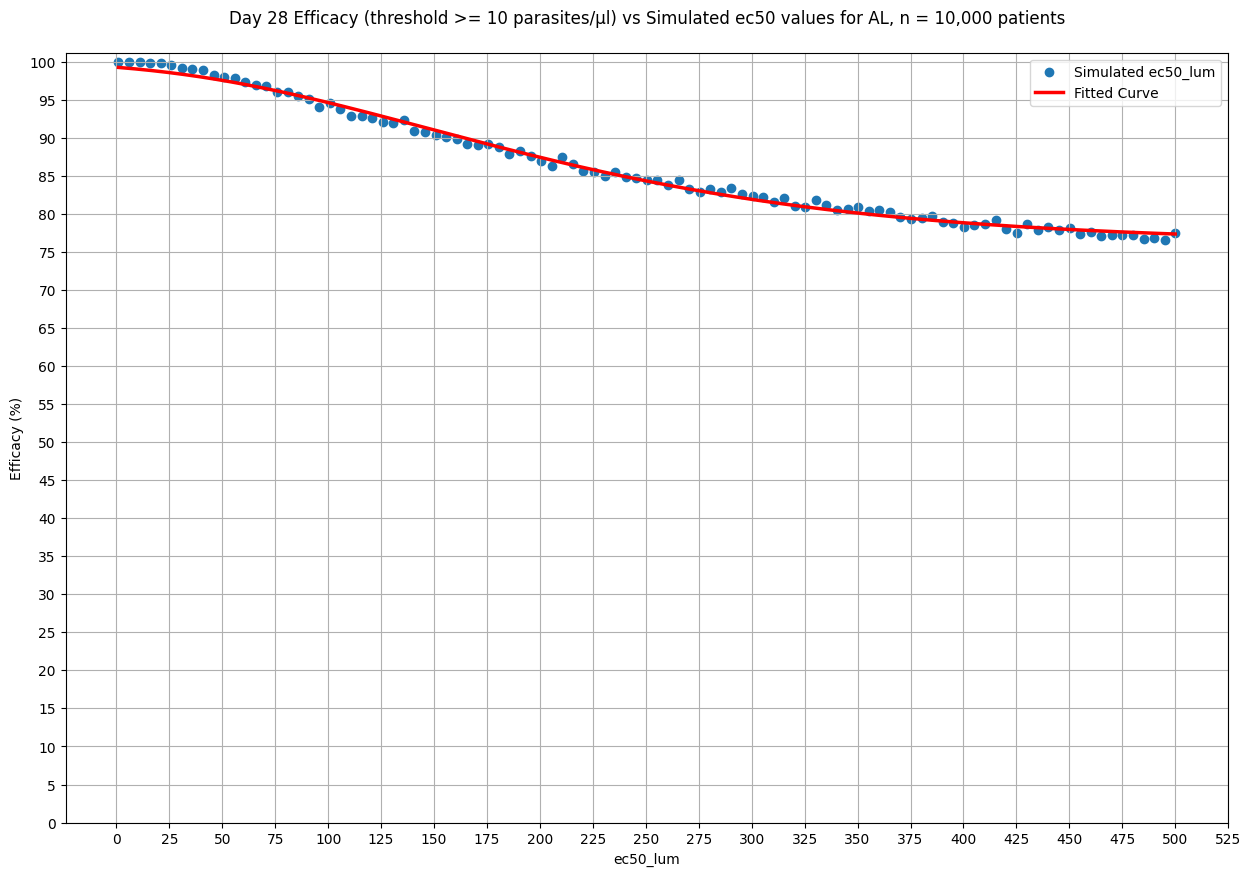

In [757]:
# Plot results
plt.figure(figsize=(15, 10))
plt.scatter(xdata, ydata, label='Simulated ec50_lum')
#plt.plot(xdata, fitted_values, label='Fitted Curve', color='red')
plt.plot(x_smooth, fitted_values_richards, label='Fitted Curve', color='red', linewidth=2.5)

# for efficacy in y_targets:
#     plt.axhline(y=efficacy,linestyle='--', label=f'Target efficacy = {y_target}')
# for ec50 in x_targets:
#     plt.axvline(x=ec50, linestyle='--', label=f'Extrapolated ec50 = {ec50:.1f}')

plt.xticks(np.arange(0, max(data_ec50_lum['ec50_lum'])+26,25))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 102, 5))  # Y-axis ticks from min(ydata) to 100%
plt.xlabel("ec50_lum")
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated ec50 values for AL, n = 10,000 patients\n")
plt.legend()
plt.grid(True)
plt.savefig(f"pkpd_AL_{file_suffix}_sigmoid_richards_01.png")
plt.show()

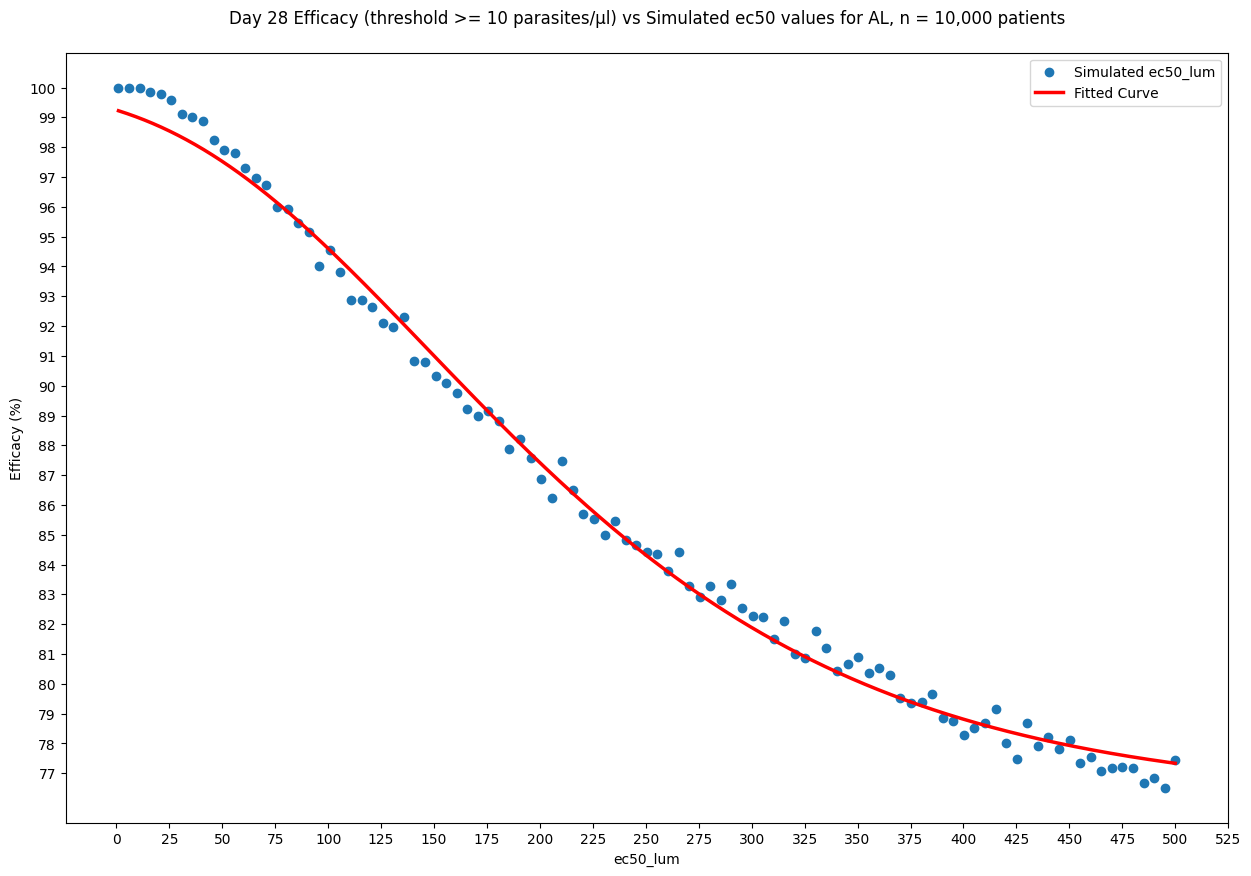

In [758]:
# Plot results
plt.figure(figsize=(15, 10))
plt.scatter(xdata, ydata, label='Simulated ec50_lum')
#plt.plot(xdata, fitted_values, label='Fitted Curve', color='red')
plt.plot(x_smooth, fitted_values_richards, label='Fitted Curve', color='red', linewidth=2.5)

# for efficacy in y_targets:
#     plt.axhline(y=efficacy,linestyle='--', label=f'Target efficacy = {y_target}')
# for ec50 in x_targets:
#     plt.axvline(x=ec50, linestyle='--', label=f'Extrapolated ec50 = {ec50:.1f}')

plt.xticks(np.arange(0, max(data_ec50_lum['ec50_lum'])+26,25))  # Adjust tick marks if necessary
plt.yticks(np.arange(round(min(ydata), 0), 101, 1))  # Y-axis ticks from min(ydata) to 100%
plt.xlabel("ec50_lum")
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated ec50 values for AL, n = 10,000 patients\n")
plt.legend()
plt.savefig(f"pkpd_AL_{file_suffix}_sigmoid_richards_02.png")
plt.show()

In [823]:
# Sigmoid function
def sigmoid_richards(x, K, x0, B, A, Q, v):
#def sigmoid_richards(x, L, x0, k, b, v):
    exp_term = np.exp(-np.clip(B * (x - x0), -700, 700))
    y = A + (K-A)/((1 + (Q * exp_term))**(1/v))
    return y

# Data
xdata = np.array(data_ec50_lum['ec50_lum'])
ydata = np.array(data_ec50_lum['efficacy'])
x_min, x_max = np.min(xdata), np.max(xdata)

# Normalize the original xdata for fitting
#xdata_norm = (xdata - x_min) / (x_max - x_min)

# --- 2. Fit the Curve using Original Data ---
# Initial guess
K = 0
x0 = np.median(xdata)  # Using median of xdata for initial x0
B = -0.005 # Steepness (can be tuned)
A = 100
Q = 1
v = 1

# Define bounds for the parameters [K, x0, B, A, Q, v] 
lower_bounds = [0, 0, -np.inf, 0, 0, -np.inf]  
# Upper bounds: L, x0, k, b 
upper_bounds = [1, np.inf, 0, 100, 1, np.inf]

bounds = (lower_bounds, upper_bounds)

p0 = [K, x0, B, A, Q, v]


# Note: xdata and ydata have the same length
#popt, pcov = curve_fit(sigmoid, xdata_norm, ydata, p0, bounds=bounds,maxfev=10000)
popt, pcov = curve_fit(sigmoid_richards, xdata, ydata, p0, bounds=bounds,maxfev=10000)

print("K:", popt[0], "x0:", popt[1], "B:", popt[2], "A:", popt[3], "Q:", popt[4], "v:", popt[5])


K: 0.20177056243237843 x0: 233.3503523798932 B: -0.0013054084222445272 A: 86.23267326732817 Q: 0.9999999999068462 v: 0.011983610422284352


In [824]:
x_smooth = np.linspace(x_min, x_max, 10000)
#x_smooth_norm = (x_smooth - x_min) / (x_max - x_min)
#fitted_values = sigmoid(x_smooth_norm, *popt)
fitted_values_richards = sigmoid_richards(x_smooth, *popt)

# Function to extrapolate x given y
def extrapolate_x_richards(y, L, x0, k, b, Q, v):
    # Solve for x
    exponent = (K-A/(y-A))**(v)
    x = x0 - (1/B) * np.log((exponent - 1)/Q)
    #x = x0 - (1 / k) * np.log((L / y) - 1) # Without b 
    return x

# Example: Extrapolate x for a given y
y_target = 92.5 # Example efficacy value
#x_target_norm = extrapolate_x(y_target, *popt)
x_target = extrapolate_x_richards(y_target, *popt)

# Rescale to original x range
#x_target = x_target_norm * (x_max - x_min) + x_min
print(f"The ec50 value x for the efficacy y = {y_target} is approximately {x_target:.10f}")

The ec50 value x for the efficacy y = 92.5 is approximately -458.0284105665


In [825]:
# Repeat for other efficacy values

y_targets = [87.5, 91.9, 92.5, 96.5, 99.999] # Example efficacy value
x_targets = []

for efficacy in y_targets:
    #x_target_norm = extrapolate_x(efficacy, *popt)
    x_target = extrapolate_x_richards(efficacy, *popt)
    # Rescale to original x range
    #x_target = x_target_norm * (x_max - x_min) + x_min
    x_target = max(1, x_target) 
    x_targets.append(round(x_target,1))
    print(f"The ec50 value x for the efficacy y = {efficacy} is approximately {x_target:.10f}")

The ec50 value x for the efficacy y = 87.5 is approximately 1.0000000000
The ec50 value x for the efficacy y = 91.9 is approximately 1.0000000000
The ec50 value x for the efficacy y = 92.5 is approximately 1.0000000000
The ec50 value x for the efficacy y = 96.5 is approximately 1.0000000000
The ec50 value x for the efficacy y = 99.999 is approximately 1.0000000000


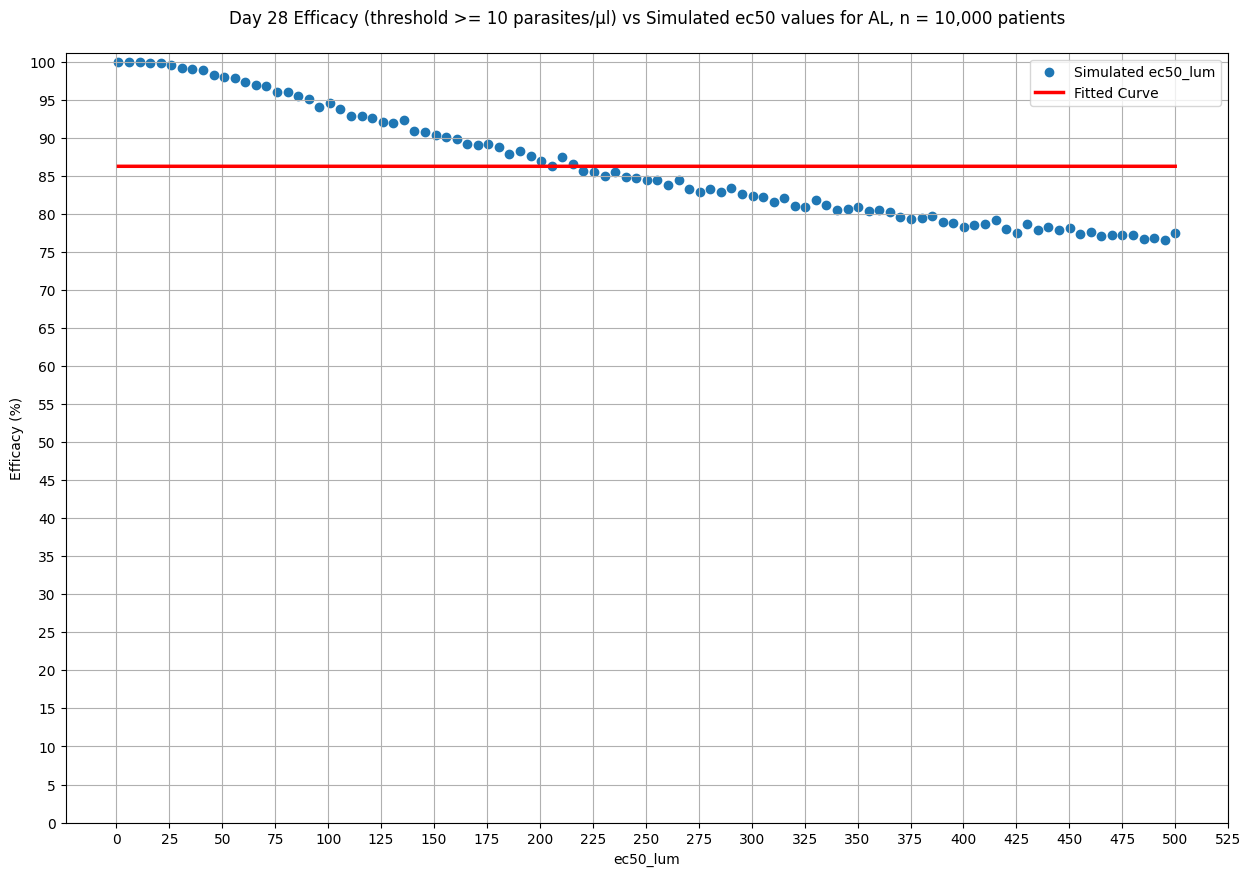

In [826]:
# Plot results
plt.figure(figsize=(15, 10))
plt.scatter(xdata, ydata, label='Simulated ec50_lum')
#plt.plot(xdata, fitted_values, label='Fitted Curve', color='red')
plt.plot(x_smooth, fitted_values_richards, label='Fitted Curve', color='red', linewidth=2.5)

# for efficacy in y_targets:
#     plt.axhline(y=efficacy,linestyle='--', label=f'Target efficacy = {y_target}')
# for ec50 in x_targets:
#     plt.axvline(x=ec50, linestyle='--', label=f'Extrapolated ec50 = {ec50:.1f}')

plt.xticks(np.arange(0, max(data_ec50_lum['ec50_lum'])+26,25))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 102, 5))  # Y-axis ticks from min(ydata) to 100%
plt.xlabel("ec50_lum")
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated ec50 values for AL, n = 10,000 patients\n")
plt.legend()
plt.grid(True)
plt.savefig(f"pkpd_AL_{file_suffix}_sigmoid_richards_01.png")
plt.show()

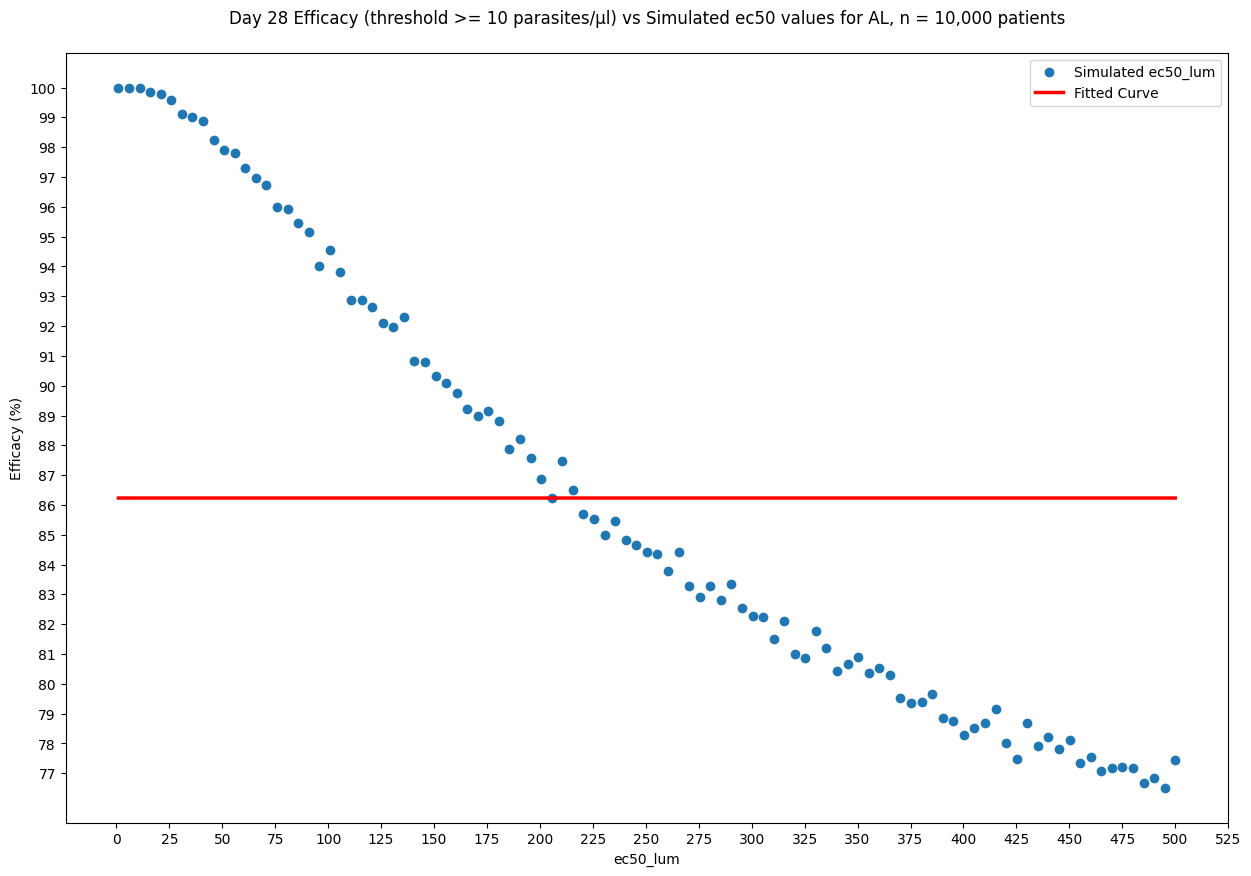

In [822]:
# Plot results
plt.figure(figsize=(15, 10))
plt.scatter(xdata, ydata, label='Simulated ec50_lum')
#plt.plot(xdata, fitted_values, label='Fitted Curve', color='red')
plt.plot(x_smooth, fitted_values_richards, label='Fitted Curve', color='red', linewidth=2.5)

# for efficacy in y_targets:
#     plt.axhline(y=efficacy,linestyle='--', label=f'Target efficacy = {y_target}')
# for ec50 in x_targets:
#     plt.axvline(x=ec50, linestyle='--', label=f'Extrapolated ec50 = {ec50:.1f}')

plt.xticks(np.arange(0, max(data_ec50_lum['ec50_lum'])+26,25))  # Adjust tick marks if necessary
plt.yticks(np.arange(round(min(ydata), 0), 101, 1))  # Y-axis ticks from min(ydata) to 100%
plt.xlabel("ec50_lum")
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated ec50 values for AL, n = 10,000 patients\n")
plt.legend()
plt.savefig(f"pkpd_AL_{file_suffix}_sigmoid_richards_02.png")
plt.show()

In [827]:
# The 5-parameter logistic function
def sigmoid_5pl(x, L, x0, k, b, g):
    exp_term = np.exp(-np.clip(k * (x - x0), -700, 700))
    y = b + (L - b) / ((1 + exp_term)**g)
    return y

xdata = np.array(data_ec50_lum['ec50_lum'])
ydata = np.array(data_ec50_lum['efficacy'])
x_min, x_max = np.min(xdata), np.max(xdata)

In [828]:
L = 100
x0 = np.median(xdata)  # Using median of xdata for initial x0
k = -0.005 # Steepness (can be tuned)
b = 1
g = 2

In [829]:
# Define bounds for the parameters [L, x0, k, b, g] 
lower_bounds = [0, 0, -np.inf, 0, -np.inf]  
# Upper bounds: L, x0, k, b , g
upper_bounds = [100, np.inf, 0, 100, np.inf]

bounds = (lower_bounds, upper_bounds)

p0 = [L, x0, k, b, g]


# Note: xdata and ydata have the same length
#popt, pcov = curve_fit(sigmoid, xdata_norm, ydata, p0, bounds=bounds,maxfev=10000)
popt, pcov = curve_fit(sigmoid_5pl, xdata, ydata, p0, bounds=bounds,maxfev=10000)

print("L:", popt[0], "x0:", popt[1], "k:", popt[2], "b:", popt[3], "g:", popt[4])


L: 99.99999999999999 x0: 38.988492453849176 k: -0.06433771944280572 b: 71.32181426464847 g: 0.0570296345240469


In [833]:
x_smooth = np.linspace(x_min, x_max, 10000)
#x_smooth_norm = (x_smooth - x_min) / (x_max - x_min)
#fitted_values = sigmoid(x_smooth_norm, *popt)
fitted_values_5pl = sigmoid_5pl(x_smooth, *popt)

# Function to extrapolate x given y
def extrapolate_x_5pl(y, L, x0, k, b, g):
    # Solve for x
    x = x0 - (1/k) * np.log( ((L-b)/(y-b))**(1/g) - 1 )
    return x

# Example: Extrapolate x for a given y
y_target = 92.5 # Example efficacy value
#x_target_norm = extrapolate_x(y_target, *popt)
x_target = extrapolate_x_5pl(y_target, *popt)

# Rescale to original x range
#x_target = x_target_norm * (x_max - x_min) + x_min
print(f"The ec50 value x for the efficacy y = {y_target} is approximately {x_target:.10f}")

The ec50 value x for the efficacy y = 92.5 is approximately 121.5372211838


In [834]:
# Repeat for other efficacy values

y_targets = [87.5, 91.9, 92.5, 96.5, 99.999] # Example efficacy value
x_targets = []

for efficacy in y_targets:
    #x_target_norm = extrapolate_x(efficacy, *popt)
    x_target = extrapolate_x_5pl(efficacy, *popt)
    # Rescale to original x range
    #x_target = x_target_norm * (x_max - x_min) + x_min
    x_target = max(1, x_target) 
    x_targets.append(round(x_target,1))
    print(f"The ec50 value x for the efficacy y = {efficacy} is approximately {x_target:.10f}")

The ec50 value x for the efficacy y = 87.5 is approximately 195.0108555496
The ec50 value x for the efficacy y = 91.9 is approximately 129.4004601323
The ec50 value x for the efficacy y = 92.5 is approximately 121.5372211838
The ec50 value x for the efficacy y = 96.5 is approximately 72.7892066535
The ec50 value x for the efficacy y = 99.999 is approximately 1.0000000000


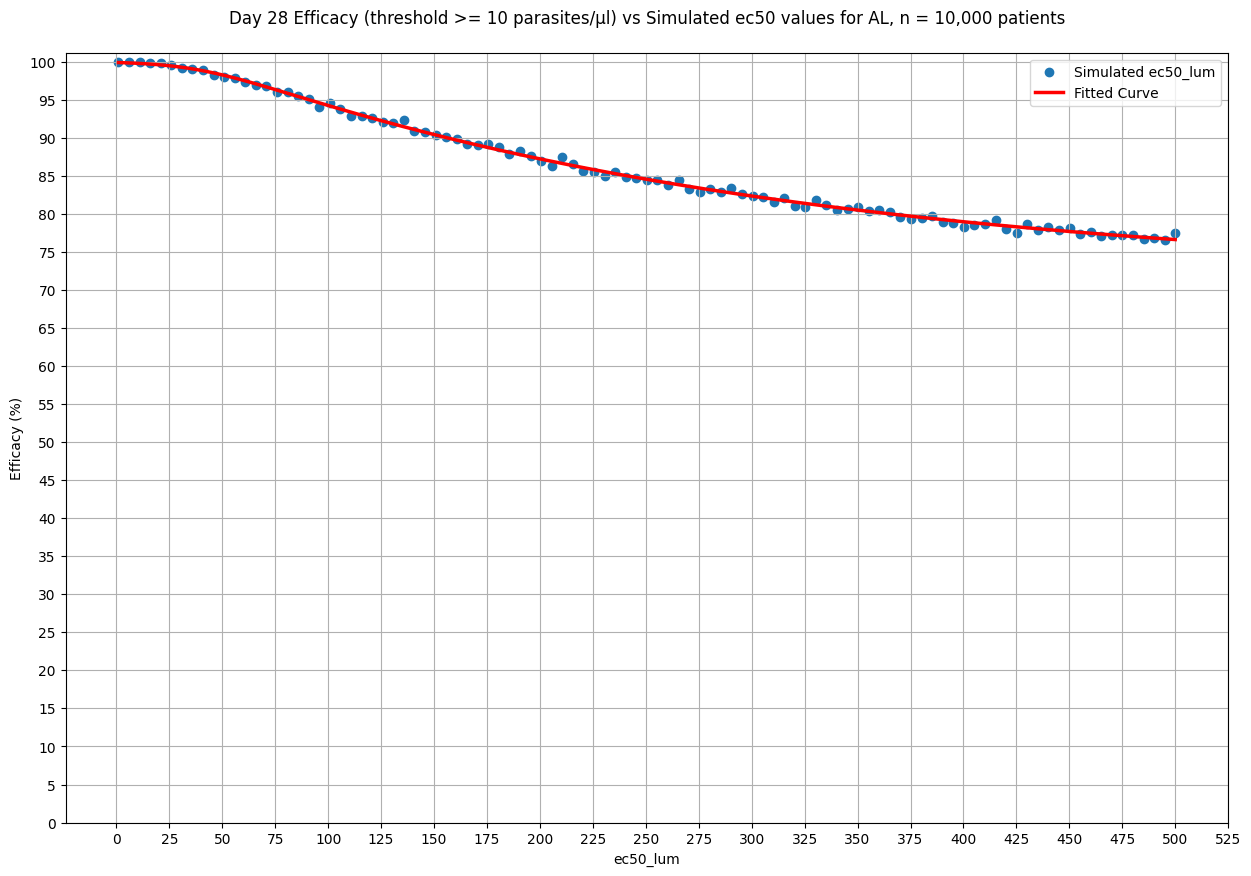

In [835]:
# Plot results
plt.figure(figsize=(15, 10))
plt.scatter(xdata, ydata, label='Simulated ec50_lum')
#plt.plot(xdata, fitted_values, label='Fitted Curve', color='red')
plt.plot(x_smooth, fitted_values_5pl, label='Fitted Curve', color='red', linewidth=2.5)

# for efficacy in y_targets:
#     plt.axhline(y=efficacy,linestyle='--', label=f'Target efficacy = {y_target}')
# for ec50 in x_targets:
#     plt.axvline(x=ec50, linestyle='--', label=f'Extrapolated ec50 = {ec50:.1f}')

plt.xticks(np.arange(0, max(data_ec50_lum['ec50_lum'])+26,25))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 102, 5))  # Y-axis ticks from min(ydata) to 100%
plt.xlabel("ec50_lum")
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated ec50 values for AL, n = 10,000 patients\n")
plt.legend()
plt.grid(True)
plt.savefig(f"pkpd_AL_{file_suffix}_sigmoid_5pl_01.png")
plt.show()

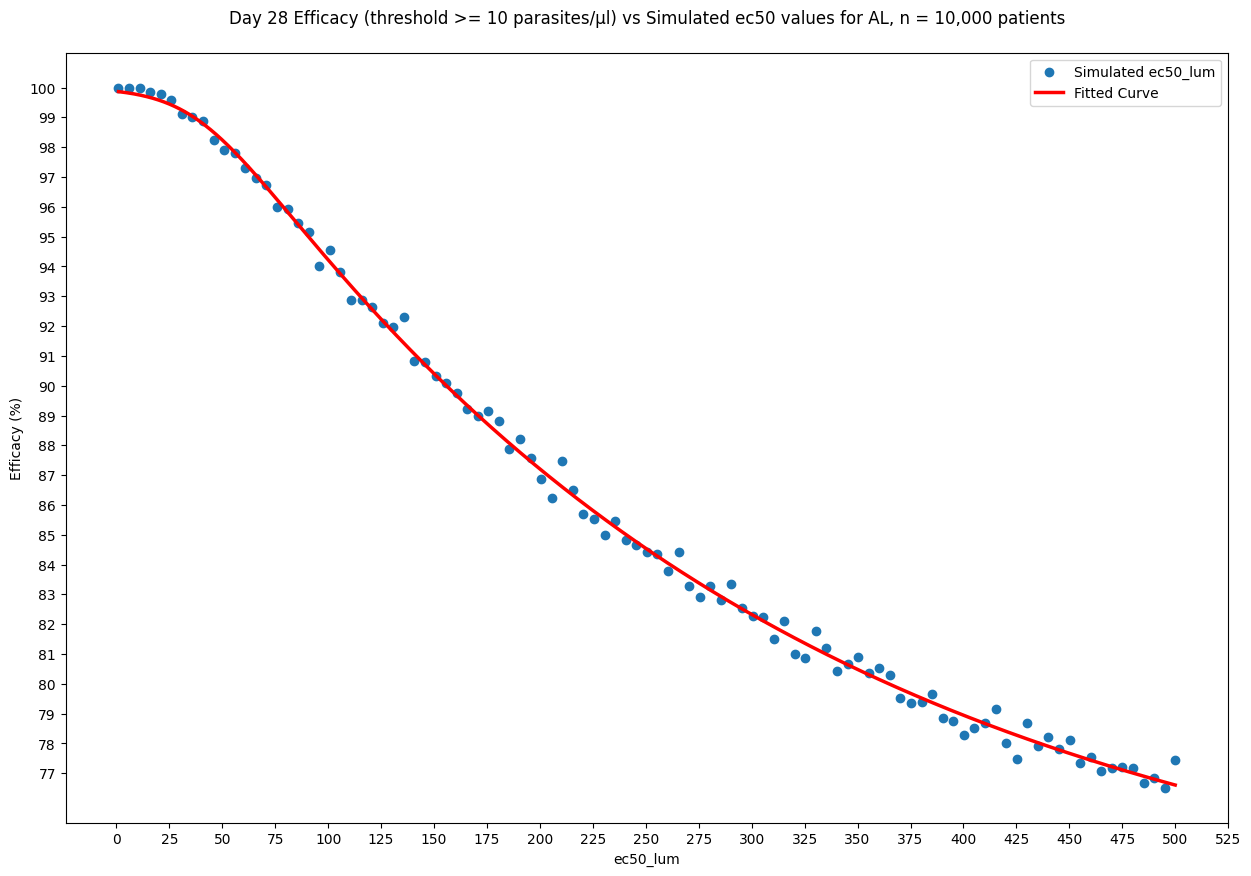

In [836]:
# Plot results
plt.figure(figsize=(15, 10))
plt.scatter(xdata, ydata, label='Simulated ec50_lum')
#plt.plot(xdata, fitted_values, label='Fitted Curve', color='red')
plt.plot(x_smooth, fitted_values_5pl, label='Fitted Curve', color='red', linewidth=2.5)

# for efficacy in y_targets:
#     plt.axhline(y=efficacy,linestyle='--', label=f'Target efficacy = {y_target}')
# for ec50 in x_targets:
#     plt.axvline(x=ec50, linestyle='--', label=f'Extrapolated ec50 = {ec50:.1f}')

plt.xticks(np.arange(0, max(data_ec50_lum['ec50_lum'])+26,25))  # Adjust tick marks if necessary
plt.yticks(np.arange(round(min(ydata), 0), 101, 1))  # Y-axis ticks from min(ydata) to 100%
plt.xlabel("ec50_lum")
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated ec50 values for AL, n = 10,000 patients\n")
plt.legend()
plt.savefig(f"pkpd_AL_{file_suffix}_sigmoid_5pl_02.png")
plt.show()